In [43]:
import networkx
import matplotlib.pyplot as plt 
from IPython.core.display import SVG, display




/var/folders/8q/8dmdx6bd2593mlj4l_q1htk80000gn/T/ipykernel_15383/128931876.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import SVG, display


Genetic sequences are represented in the form of a port graph in which nodes represent source sequences, and ports represent linear coordinates on that source sequence.


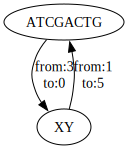

In [71]:
# Create an empty graph
G = nx.DiGraph()

# We store the source sequences as a hash table, they are unique and unassociated with any metadata other than where to find them (drive, url, ...)
# For the sake of this example, we don't calculate the hash and use a simple dictionary.
sequence_hashes = {'h1': 'ATCGACTG', 
                   'h2': 'XY', 
                   'h3': 'Z'}

# Sequence nodes are instantiations of source sequences, they do not have to be unique and are well suited to carry metadata.
# They are referenced by an identifier that is unique within the graph, let's use an integer for now.
G.add_node(1,  sequence_hash = 'h1')

# An sequence variant or edit is represented by edges and sequence nodes, 
# we demonstrate this for a substitution: Replace GA by XY

# Add a new sequence node to represent the insert
G.add_node(2, sequence_hash='h2')

# In a ported graph, edges are defined by the source and target nodes, and the ports on each node.
# In this case ports correspond to positions: (source node, from position), (target node, to position)
def add_port_edge(graph, source, target):
    # We use edge attributes to store the port information:
    graph.add_edge(source[0], target[0], from_pos=source[1], to_pos=target[1])

# We add two edges between nodes 1 and 2
add_port_edge(G, (1, 3), (2, 0)) # From node 1, position 3 to node 2, position 0
add_port_edge(G, (2, 1), (1, 5)) # From node 2, position 1 to node 1, position 5

# Let's plot the graph
def draw_graph(graph):
    # Add the actual sequence as node label
    for node in graph.nodes:
        graph.nodes[node]['label'] = sequence_hashes[graph.nodes[node]['sequence_hash']]
    # Add the port information as edge label
    for edge in graph.edges:
        graph.edges[edge]['label'] = f"from:{graph.edges[edge]['from_pos']}\nto:{graph.edges[edge]['to_pos']}"
    # Convert the networkx graph to a pygraphviz graph
    graph = nx.nx_agraph.to_agraph(graph)
    # Allow multiple edges between the same nodes
    graph.graph_attr['multiedges'] = 'true'
    # Draw the graph using pygraphviz
    fig = SVG(graph.draw(prog='dot', args='-Goverlap=false', format='svg'))
    display(fig)

draw_graph(G)


In [58]:
for i in graph.edges(data=True):
    print(i)

(1, 2, {})
(2, 1, {})


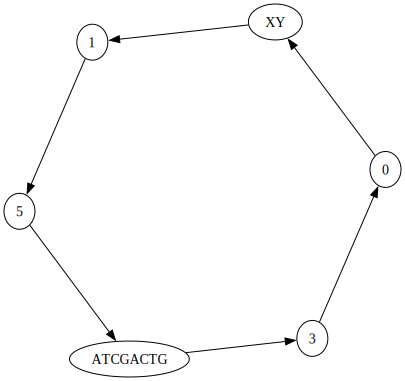

In [76]:
def draw_graph_ported(graph):
    # Create a new graph to store the ported version
    port_graph = graph.copy()

    # Iterate over the edges of the original graph
    for source, target, edge_attrs in graph.edges(data=True):
        from_pos = edge_attrs.get('from_pos')
        to_pos = edge_attrs.get('to_pos')

        # Add port nodes addressed by a (node, position) tuple
        port_graph.add_node((source, from_pos), label=from_pos)
        port_graph.add_node((target, to_pos), label=to_pos)

        # Add edges between the sequence nodes and their ports
        port_graph.add_edge(source, (source, from_pos))
        port_graph.add_edge((target, to_pos), target)

        # Add an edge between the ports and remove the original edge
        port_graph.add_edge((source, from_pos), (target, to_pos))
        port_graph.remove_edge(source, target)

    # Sequence nodes are labeled by sequence, port nodes by position
    for node in port_graph.nodes:
        if isinstance(node, tuple):
            port_graph.nodes[node]['label'] = node[1]
            port_graph.nodes[node]['width'] = 0.1
            port_graph.nodes[node]['height'] = 0.5
        else:
            port_graph.nodes[node]['label'] = sequence_hashes[port_graph.nodes[node]['sequence_hash']]

    # Convert the networkx graph to a pygraphviz graph
    port_graph = nx.nx_agraph.to_agraph(port_graph)
    # Allow multiple edges between the same nodes
    port_graph.graph_attr['multiedges'] = 'true'
    # Draw the graph using pygraphviz
    fig = SVG(port_graph.draw(prog='neato', args='-Goverlap=false', format='svg'))
    display(fig)

draw_graph_ported(G)
    

    

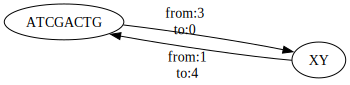

In [62]:


# Edges connect sequence nodes via  ports that represent a position on the sequence between coordinates.
# To implement this, I store the positions on the edge itself
G.add_edge(1,2, from_pos=3, to_pos=0, label=f'from:{3}\nto:{0}')
G.add_edge(2,1, from_pos=1, to_pos=34, label=f'from:{1}\nto:{4}')


# Draw the graph so that nodes show the source sequences
def draw_graph(G):
    # Add the actual sequence as label
    for node in G.nodes:
        G.nodes[node]['label'] = sequence_hashes[G.nodes[node]['sequence_hash']]
    # Convert the networkx graph to a pygraphviz graph
    G = nx.nx_agraph.to_agraph(G)
    # Allow multiple edges between the same nodes
    G.graph_attr['multiedges'] = 'true'
    
    # Draw the graph using matplotlib
    fig = SVG(G.draw(prog='neato', args='-Goverlap=false', format='svg'))
    display(fig)

draw_graph(G)



Another way to represent a port graph is by drawing the ports as a type of nodes themselves:

In [ ]:
# Create a new empty graph
G = nx.DiGraph()

# Iterate over the edges of the original graph
for source, target, edge_attrs in G.edges(data=True):
    # Get the port attributes from the original edge
    from_pos = edge_attrs.pop('from_pos')
    to_pos = edge_attrs.pop('to_pos')
    label = edge_attrs.pop('label')
    
    # Add a new node representing the port
    port_node = len(G) + 1
    G.add_node(port_node, label=label)
    
    # Add edges between the source node and the port node, and between the port node and the target node
    G.add_edge(source, port_node)
    G.add_edge(port_node, target)
    
    # Set the attributes of the port node
    G.nodes[port_node]['from_pos'] = from_pos
    G.nodes[port_node]['to_pos'] = to_pos
    
# Display the new graph
display(SVG(nx.nx_agraph.to_agraph(G).draw(prog='neato', args='-Goverlap=false', format='svg')))